In [14]:
from google.colab import drive
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# mount project dir
drive.mount('/content/gdrive')
# !ls '/content/gdrive/My Drive/'
path = '/content/gdrive/MyDrive/'
project_path = path + 'LR Research/Coding/notebooks-Colab/gate_detection/'
gate_path = path + 'TU Delft/Brightspace Courses/AE4317/Washington_OB_Race/Gate_Imgs/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We are interested in detecting the next closest gate in the track, but the most important is to detect the flyable area that allows the drone to cross the gate. For this task, the bounding box should not enclose the entire gate; instead detects the inner area of the gate. Thus the SSD network is selected to perform this objective due to its high accuracy reported; we use a reduced variant named SSD7 that has only seven convolutional layers.

AlexNet and GoogLeNet [13], [14] showed excellent speed and performance in the ImageNet competition, and algorithms such as SSD and YOLO [4], [15] showed good performance in the detection part.

However, these algorithms were still inadequate in terms of the computing power requirement imposed on an embedded system.

When we overlay a single channel of our target (or prediction), we refer to this as a *mask* which illuminates the regions of an image where a specific class is present.

Ronneberger et al. (U-Net paper) discuss a loss weighting scheme for each pixel such that there is a higher weight at the border of segmented objects.

In [15]:
# get the CSV and the annotations
corner_landmarks = pd.read_csv(gate_path + 'corners.csv', header=None)
print(corner_landmarks, '\n')
# pick an image
n = 200
img_name = corner_landmarks.iloc[n, 0]
img_corners = corner_landmarks.iloc[n, 1:].to_numpy()
# get all corners from this image
while corner_landmarks.iloc[n, 0] == corner_landmarks.iloc[n+1, 0]:
    corner_to_append = corner_landmarks.iloc[n+1, 1:].to_numpy()
    img_corners = np.append(img_corners, corner_to_append)
    n += 1

img_corners = img_corners.astype('float').reshape(-1, 2)

               0    1    2    3    4    5    6    7    8
0     img_10.png   99  179  172  179  173  241  101  251
1     img_10.png   22  198   63  197   62  233   20  238
2     img_11.png   97  201  170  199  172  262   97  273
3     img_11.png   22  219   63  218   62  252   19  258
4    img_110.png  161  128  212  131  209  182  158  181
..           ...  ...  ...  ...  ...  ...  ...  ...  ...
685   img_74.png  100  217  123  219  122  238  100  238
686    img_8.png   91  134  164  135  167  197   93  203
687    img_8.png    4  147   47  149   49  185    6  186
688    img_9.png  104  154  176  155  180  217  109  226
689    img_9.png   22  172   67  173   68  208   23  211

[690 rows x 9 columns] 



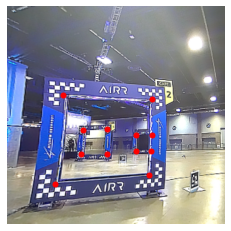

In [16]:
# a helper function to show an image and its corners
def show_landmarks(img, corners):
    plt.axis('off')
    plt.imshow(img)
    plt.scatter(corners[:, 0], corners[:, 1], s=100, marker='.', c='r')
    
show_landmarks(io.imread(os.path.join(gate_path, img_name)), img_corners)

## Build the Dataset

`torch.utils.data.Dataset` is an abstract class representing a dataset. The `GateDataset` should 
inherit `Dataset` and override the 
following methods:
+ `__len__` so that `len(dataset)` returns the size of the dataset.
+ `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$th sample.


In [17]:
class GateDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.gate_corner_frames = pd.read_csv(csv_file, header=None)
        self.gate_img_names = []
        self.gate_mask_names = []
        self.cnt_img = 0
        self.cnt_mask = 0

        for root, dirs, files in os.walk(self.root_dir):
            for filename in files:
                if filename[:4] == 'img_':
                    self.cnt_img += 1
                    self.gate_img_names.append(filename)
                    self.gate_mask_names.append('mask_' + filename[4:])
                elif filename[:4] == 'mask':
                    self.cnt_mask += 1
        
        assert self.cnt_img == self.cnt_mask == len(self.gate_mask_names) \
                            == len(self.gate_img_names), "Number of masks and imgs need to be the same"
        
        
    def __len__(self):
        return self.cnt_img
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.gate_img_names[idx])
        mask_name = os.path.join(self.root_dir, self.gate_mask_names[idx])
        img = io.imread(img_name)
        mask = io.imread(mask_name)
        sample = {'img': img, 'mask': mask}
        
        # apply transform if transform is not None
        if self.transform:
            sample = self.transform(sample)

        return sample

# initialzie the dataset
gate_dataset = GateDataset(gate_path + 'corners.csv', gate_path)

Now we have built the dataset for gates and masks, the `GateDataset` can iterate through the original dataset and get access to every image and mask.

40 (360, 360, 3) (360, 360)
63 (360, 360, 3) (360, 360)
189 (360, 325, 3) (360, 325)


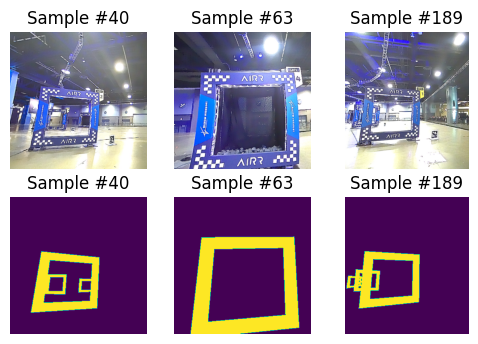

In [18]:
# plot images and masks
fig = plt.figure(dpi=100)

num_of_subs = 3
sample_seed = np.random.randint(low=1, high=300, size=num_of_subs)

for id, i in enumerate(sample_seed):
    sample = gate_dataset[i]
    print(i, sample['img'].shape, sample['mask'].shape)
    # show img
    ax1 = plt.subplot(2, num_of_subs, id + 1)
    ax1.set_title('Sample #{}'.format(i))
    ax1.axis('off')
    ax1.imshow(sample['img'])
    # show mask
    ax2 = plt.subplot(2, num_of_subs, id + num_of_subs + 1)
    ax2.set_title('Sample #{}'.format(i))
    ax2.axis('off')
    ax2.imshow(sample['mask'])

    if i == num_of_subs - 1:
        break

## Transforms

Before we feed the data into our neural network, we need `transforms` to transform the data to `tensor` and make some data augmentations.

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the image of a fixed size. Therefore, we will need to write some preprocessing code. Let's create three transforms:

+ `Rescale`: to scale the image
+ `RandomCrop`: to crop from image randomly. This is data augmentation.
+ `ToTensor`: to convert the numpy images to torch images (**we need to swap axes**).

We will write them as *callable classes* instead of simple functions so that parameters of the transform need not to be passed everytime it's called. For this, we just need to implement `__call__` method and if required, `__init__` method. We can then use a transform like this:

```python
tsfm = Transform(params) # callable object like a function
transformed_sample = tsfm(sample)
```

In [31]:
class Rescale():
    """Rescale the image in a sample to a given size."""
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple or int): Desired output size.
            If tuple, output is matched to output_size. If int,
            smaller of image edges is matched to output_size keeping
            aspect ratio the same.
        """
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        img, mask = sample['img'], sample['mask']

        h, w = img.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        rescaled_img = transform.resize(img, (new_h, new_w))
        rescaled_mask = transform.resize(mask, (new_h, new_w))

        return {'img': rescaled_img, 'mask': rescaled_mask}

class ToTensor():
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        img, mask = sample['img'], sample['mask']

        # swap color axis
        # numpy image: H x W x C
        # torch image: C x H x W
        img = img.transpose((2,0,1))

        return {'img': torch.from_numpy(img),
                'mask': torch.from_numpy(mask).unsqueeze(0)}

## Compose Transforms

Let's say we want to rescale the shorter side if the image to 256 and then randomly crop a square of size 224 from it. i.e. we want to compose `Rescale` and `RandomCrop` transforms. `torchvision.transforms.Compose` is a simple callable class which allows us to do this.



Data rescaled to new width and height: 224
162 torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
18 torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
179 torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


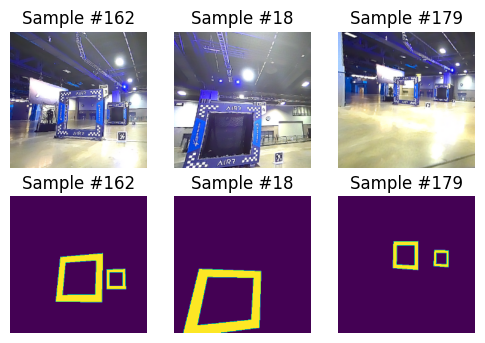

In [39]:
new_hw = 224
print("Data rescaled to new width and height:", new_hw)
tsfm_dataset = GateDataset(gate_path + 'corners.csv', gate_path,
                           transform=transforms.Compose([Rescale((new_hw, new_hw)),
                                                         ToTensor()]))

# plot images and masks
fig = plt.figure(dpi=100)

num_of_subs = 3
sample_seed = np.random.randint(low=1, high=300, size=num_of_subs)

for id, i in enumerate(sample_seed):
    sample = tsfm_dataset[i]
    print(i, sample['img'].shape, sample['mask'].shape)
    # show img
    ax1 = plt.subplot(2, num_of_subs, id + 1)
    ax1.set_title('Sample #{}'.format(i))
    ax1.axis('off')
    ax1.imshow(sample['img'].numpy().transpose(1, 2, 0))
    # show mask
    ax2 = plt.subplot(2, num_of_subs, id + num_of_subs + 1)
    ax2.set_title('Sample #{}'.format(i))
    ax2.axis('off')
    ax2.imshow(sample['mask'].squeeze(0).numpy())

    if i == num_of_subs - 1:
        break

## Iterating through the dataset by using `DataLoader`

Let's put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

 1. An image is read from the file on the fly
 2. Transforms are applied on the read image
 3. Since one of the transforms is random, data is augmentated on sampling

However, we are losing a lot of features by using a simple `for` loop to iterate over the data. In particular, we are missing out on:

+ Batching the data
+ Shuffling the data
+ Load the data in parallel using `multiprocessing` workers

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is `collate_fn`. You can specify how exactly the sample need to be batched using `collate_fn`. However, default collate should work fine for most use cases.